In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans

import os

In [2]:
num_clusters = 6

# Extracting LAB Values

In [3]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [4]:
filenames = []
l_values = []
a_values = []
b_values = []

In [5]:
base_image_path = '../dataset_segmented/train/'
images = os.listdir(base_image_path)

In [6]:
for image_file in tqdm(images, desc="Parsing images"):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_image_path = os.path.join(base_image_path, image_file)
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Error: Unable to read image at {full_image_path}")
            continue
        
        l_mean, a_mean, b_mean = extract_lab_features(image)
        
        filenames.append(full_image_path)
        l_values.append(l_mean)
        a_values.append(a_mean)
        b_values.append(b_mean)

Parsing images: 100%|██████████| 619/619 [00:07<00:00, 84.20it/s] 


In [7]:
df = pd.DataFrame({
    'filename': filenames,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [8]:
overall_L_mean = df['L'].mean()

In [9]:
len(df)

619

# K-Means Clustering

In [10]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
df

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,filename,L,A,B,cluster
0,../dataset_segmented/train/image_00000.png,158.550807,156.860815,134.544993,2
1,../dataset_segmented/train/image_00001.png,124.032728,150.990469,138.115178,2
2,../dataset_segmented/train/image_00002.png,138.924591,159.201734,147.080896,4
3,../dataset_segmented/train/image_00003.png,151.014345,152.117308,145.606127,4
4,../dataset_segmented/train/image_00004.png,121.786032,140.691926,139.714753,0
...,...,...,...,...,...
614,../dataset_segmented/train/image_00614.png,157.206992,145.239101,131.959204,3
615,../dataset_segmented/train/image_00615.png,161.619568,140.157192,131.671981,1
616,../dataset_segmented/train/image_00616.png,157.031043,158.821805,134.064065,2
617,../dataset_segmented/train/image_00617.png,178.985393,141.401764,129.911540,1


In [13]:
# Save to .csv (optional)
df.to_csv(f'image_clusters_{num_clusters}.csv', index=False)

In [11]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# Visualizations

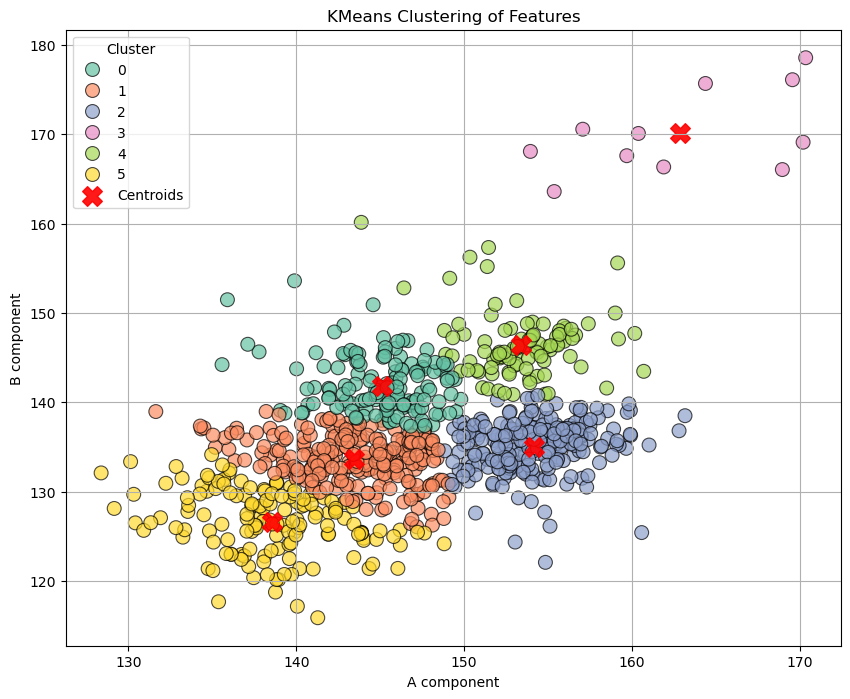

In [12]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [13]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()
cluster_max = df.groupby('cluster')[['A', 'B']].max().reset_index()
cluster_min = df.groupby('cluster')[['A', 'B']].min().reset_index()

In [14]:
cluster_means.columns = ['cluster', 'A_mean', 'B_mean']
cluster_max.columns = ['cluster', 'A_max', 'B_max']
cluster_min.columns = ['cluster', 'A_min', 'B_min']

In [15]:
combined_cluster_df = pd.merge(cluster_means, cluster_max, on='cluster')
combined_cluster_df = pd.merge(combined_cluster_df, cluster_min, on='cluster')

In [16]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min
0,0,145.094501,141.831242,149.806217,153.592231,135.576549,137.171700
1,1,143.459075,133.637028,149.095203,138.966215,131.628494,126.061935
2,2,154.143889,135.038890,163.165616,140.746588,148.843870,122.077802
3,3,162.895333,170.157737,170.356309,178.562967,153.951341,163.585719
4,4,153.413555,146.452796,160.704055,160.135631,143.871340,140.864372
5,5,138.534759,126.564575,148.812499,134.138661,128.370039,115.880877


In [17]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [18]:
cluster_means_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_mean'], x['B_mean'], overall_L_mean), axis=1)
cluster_max_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_max'], x['B_max'], overall_L_mean), axis=1)
cluster_min_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_min'], x['B_min'], overall_L_mean), axis=1)

combined_cluster_df['RGB_mean'] = cluster_means_rgb
combined_cluster_df['RGB_max'] = cluster_max_rgb
combined_cluster_df['RGB_min'] = cluster_min_rgb

In [19]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min,RGB_mean,RGB_max,RGB_min
0,0,145.094501,141.831242,149.806217,153.592231,135.576549,137.171700,"[167, 128, 114]","[189, 123, 119]","[150, 120, 105]"
1,1,143.459075,133.637028,149.095203,138.966215,131.628494,126.061935,"[152, 131, 112]","[166, 134, 118]","[128, 123, 100]"
2,2,154.143889,135.038890,163.165616,140.746588,148.843870,122.077802,"[167, 141, 123]","[184, 147, 132]","[138, 142, 117]"
3,3,162.895333,170.157737,170.356309,178.562967,153.951341,163.585719,"[228, 122, 133]","[249, 123, 141]","[208, 119, 123]"
4,4,153.413555,146.452796,160.704055,160.135631,143.871340,140.864372,"[183, 133, 123]","[212, 129, 130]","[163, 126, 112]"
5,5,138.534759,126.564575,148.812499,134.138661,128.370039,115.880877,"[135, 130, 107]","[159, 135, 117]","[105, 125, 97]"


In [20]:
combined_cluster_df.to_csv(f'cluster_colors_{num_clusters}.csv', index=False)

In [21]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A_mean']
    b_mean = row['B_mean']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

In [22]:
print(overall_L_mean)

141.52766146326005


# Image Saving

In [25]:
# Save images to cluster directories
def copy_images_to_clusters(df, base_output_dir):
    import shutil
    import os

    print(f"Base output directory: {base_output_dir}")
    os.makedirs(base_output_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copying images"):
        source_path = row['filename']
        cluster = row['cluster']
        
        cluster_dir = os.path.join(base_output_dir, f"cluster_{cluster}")
        os.makedirs(cluster_dir, exist_ok=True)
        
        filename = os.path.basename(source_path)
        dest_path = os.path.join(cluster_dir, filename)
        
        try:
            shutil.copy2(source_path, dest_path)
        except Exception as e:
            print(f"Error copying file: {e}")

In [26]:
base_output_dir = f"../clusters/{num_clusters}-clusters"
copy_images_to_clusters(df, base_output_dir)

Base output directory: ../clusters/6-clusters


Copying images: 100%|██████████| 894/894 [00:01<00:00, 752.34it/s]


In [45]:
def process_and_save_clustered_images(images, cluster_labels, output_base_dir):
    os.makedirs(output_base_dir, exist_ok=True)
    
    cluster_images = {}
    for img_name, label in zip(images, cluster_labels):
        full_image_path = os.path.join(base_image_path, img_name)
        img = cv2.imread(full_image_path)  # Reads image in BGR format
        if label not in cluster_images:
            cluster_images[label] = []
        cluster_images[label].append(img)
    
    for cluster_num, cluster_imgs in cluster_images.items():
        cluster_dir = os.path.join(output_base_dir, f'cluster_{cluster_num}')
        os.makedirs(cluster_dir, exist_ok=True)
        
        for idx, img in enumerate(cluster_imgs):
            lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            image_L_mean = np.mean(lab_img[:,:,0])
            delta_L = overall_L_mean - image_L_mean
            
            L_channel = lab_img[:,:,0].astype(np.int16)
            L_channel = L_channel + delta_L
            L_channel = np.clip(L_channel, 0, 255)
            lab_img[:,:,0] = L_channel.astype(np.uint8)
            
            # Convert back to BGR
            processed_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
            output_path = os.path.join(cluster_dir, f'image_{idx}.jpg')
            cv2.imwrite(output_path, processed_img)

In [46]:
output_directory = base_output_dir + '_processed'
process_and_save_clustered_images(images, kmeans.labels_, output_directory)

In [41]:
def find_optimal_clusters(X, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Intra-Cluster Clustering

# Elbow Method for Optimal Cluster Number

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: User

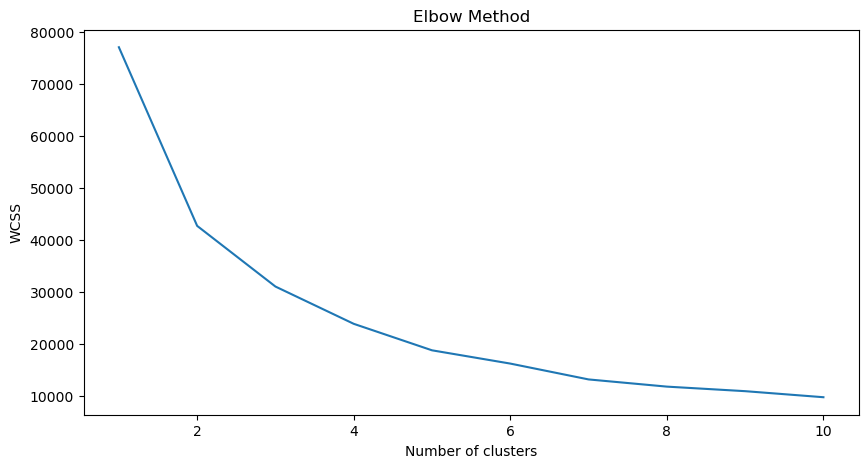

In [42]:
find_optimal_clusters(X)